<a href="https://colab.research.google.com/github/Mastemace/GZAPV_2021/blob/main/P20041/GZAPV_image_stitching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

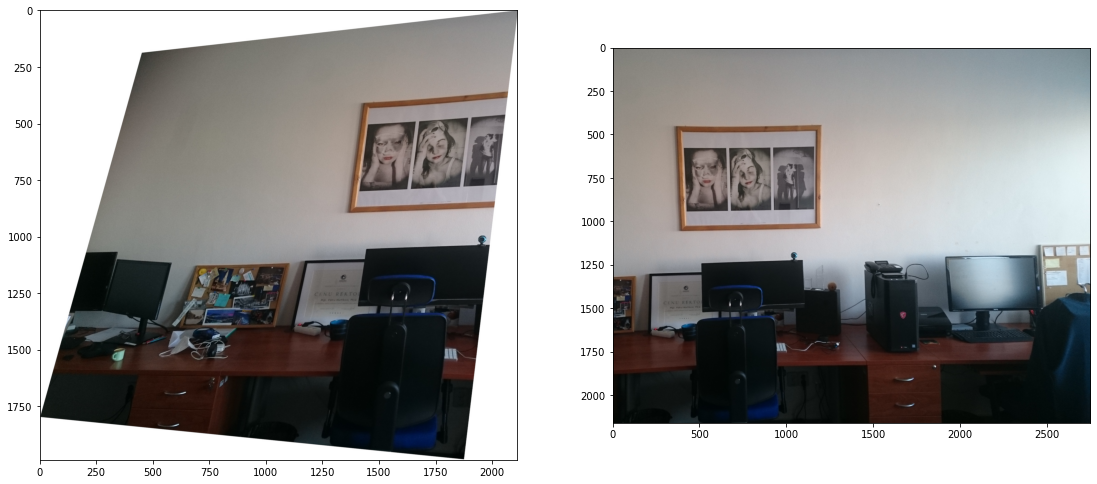

In [3]:
# http://datahacker.rs/005-how-to-create-a-panorama-image-using-opencv-with-python/

def visualize(scale, *images):
  figsize = ( images[0].shape[0] / max(images[0].shape[:2]) * scale, images[0].shape[1] / max(images[0].shape[:2]) * scale * len(images) )
  plt.figure(figsize=figsize)
  i = 1
  for id in range(len(images)):
    plt.subplot(1,len(images), i)
    plt.imshow(images[id])
    i += 1


img1 = cv2.cvtColor(cv2.imread('left_tr.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('right.jpg'), cv2.COLOR_BGR2RGB)
visualize(20, img1, img2)

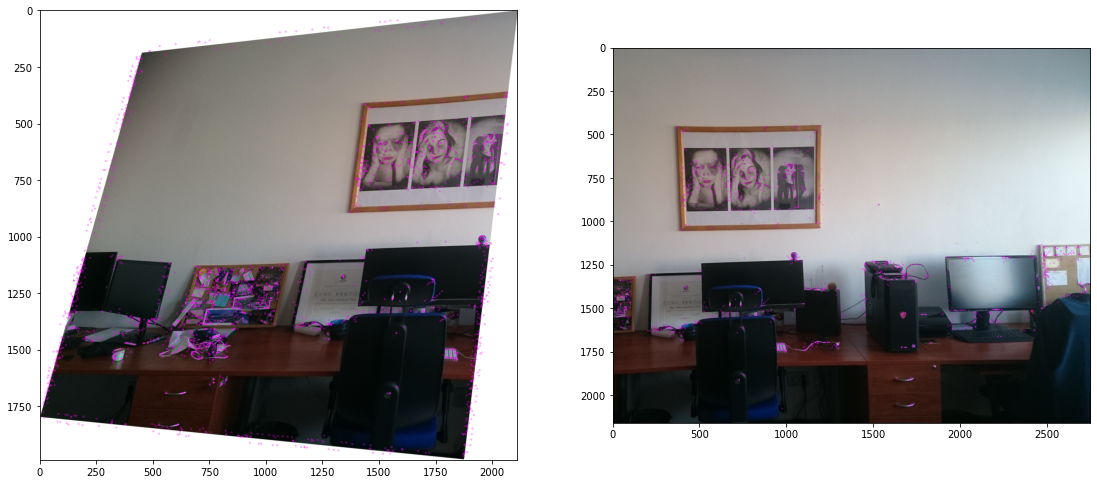

In [10]:
# Find the key points and descriptors with ORB
# https://docs.opencv.org/master/da/d9b/group__features2d.html
# https://medium.com/data-breach/introduction-to-orb-oriented-fast-and-rotated-brief-4220e8ec40cf
# https://www.researchgate.net/publication/329685512_Analysis_and_Evaluation_of_Keypoint_Descriptors_for_Image_Matching

# orb = cv2.ORB.create(1000)
# keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
# keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

kaze = cv2.KAZE.create(128)
keypoints1, descriptors1 = kaze.detectAndCompute(img1, None)
keypoints2, descriptors2 = kaze.detectAndCompute(img2, None)

out1 = cv2.drawKeypoints(img1, keypoints1, None, (255, 0, 255))
out2 = cv2.drawKeypoints(img2, keypoints2, None, (255, 0, 255))
visualize(20, out1, out2)

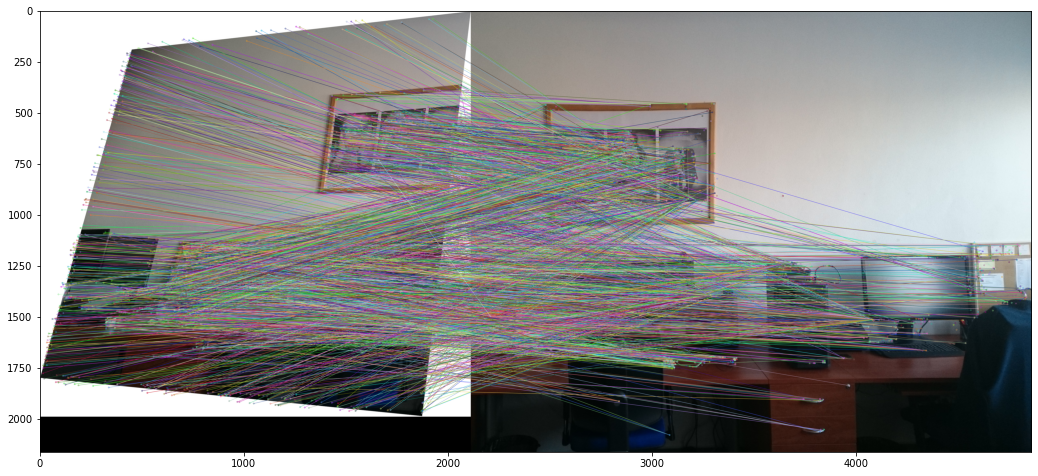

In [12]:
# ORB je binarni -> hamming matcher, mn v matchi drawKeypoints
matcher = cv2.BFMatcher_create(cv2.NORM_L2)
matches = matcher.knnMatch(descriptors1, descriptors2,k=2)
all_matches = [m for m,n in matches]
out = cv2.drawMatches(img1, keypoints1, img2, keypoints2, all_matches, None)
visualize(40, out)

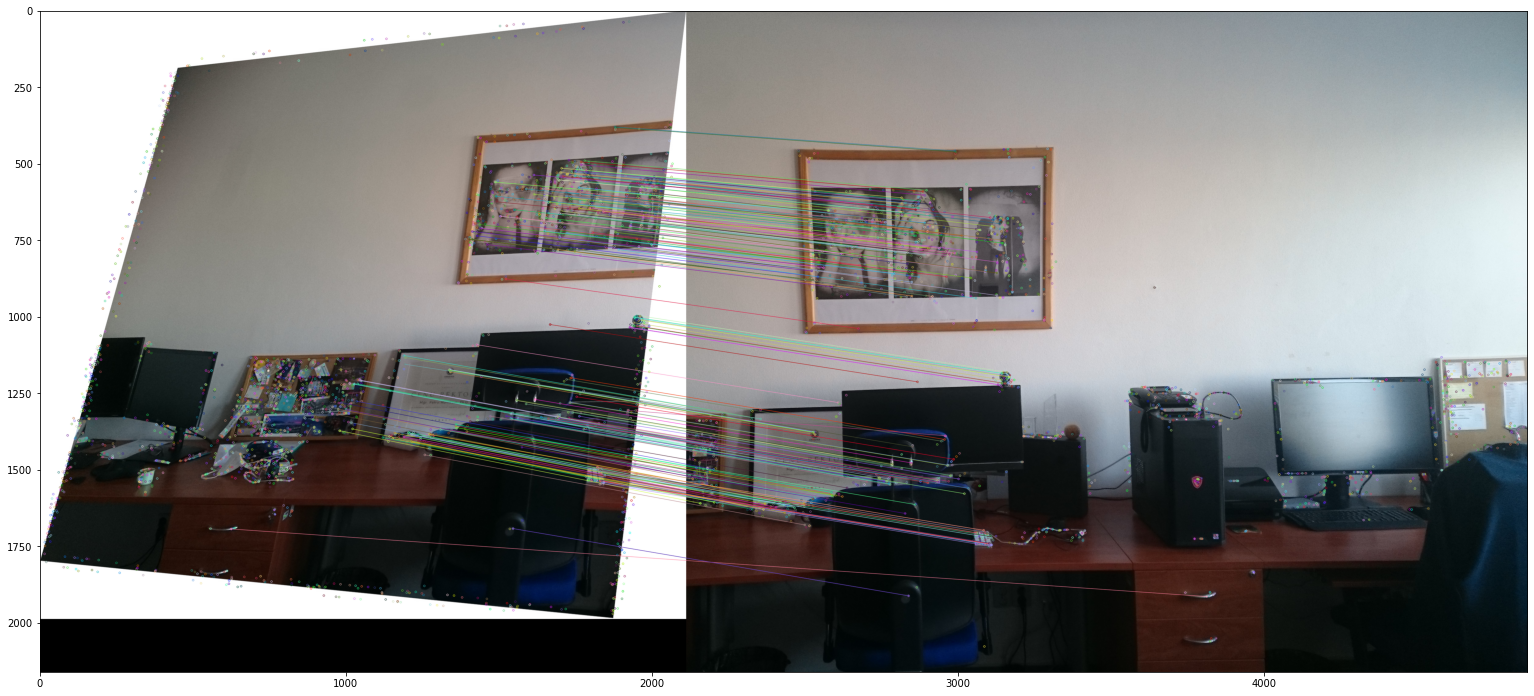

In [13]:
good = []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        good.append(m)

viz = cv2.drawMatches(img1,keypoints1,img2,keypoints2,good,None)
visualize(60, viz)

In [14]:
def warpImages(img1, img2, H):

  rows1, cols1 = img1.shape[:2]
  rows2, cols2 = img2.shape[:2]

  list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
  temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

  # When we have established a homography we need to warp perspective
  # Change field of view

  list_of_points_2 = cv2.perspectiveTransform(temp_points, H)

  list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
  
  [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
  [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
  
  translation_dist = [-x_min,-y_min]
  
  H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

  output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
  output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

  return output_img

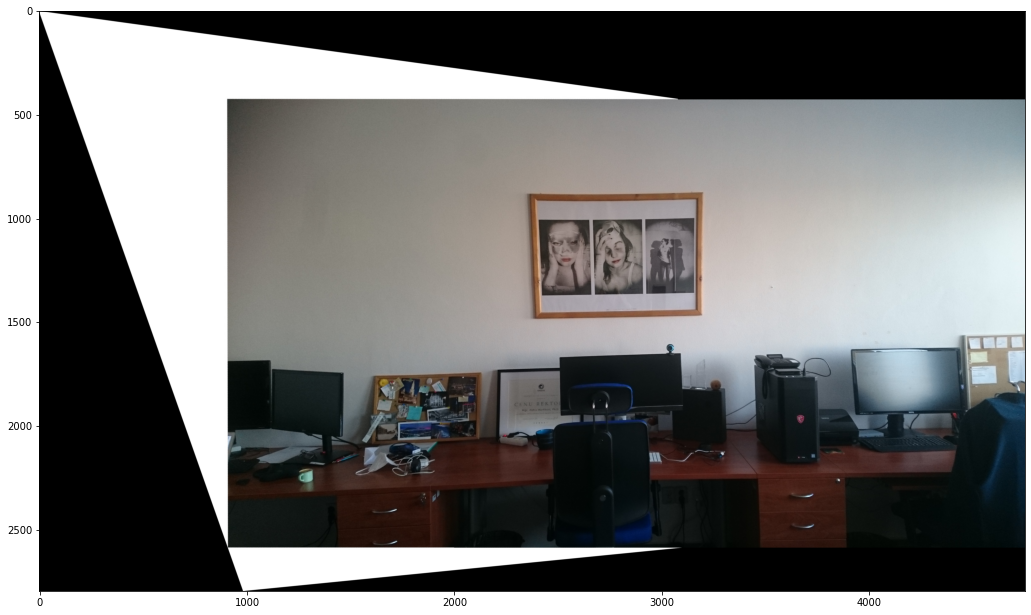

In [15]:
# Set minimum match condition
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    # Convert keypoints to an argument for findHomography
    src_pts = np.float32([ keypoints1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Establish a homography
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    
    result = warpImages(img2, img1, M)

visualize(30, result)